# Model Architecture Debug

**Goal:** Understand model shapes and gradient flow to debug training issues.

**Approach:**
1. Load small batch (2-4 events)
2. Trace forward pass: Input → T1 → Aggregation → T2 → Output
3. Inspect gradients at each stage
4. Attempt single-batch overfit

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np

from iceaggr.data import IceCubeDataset, collate_dom_packing
from iceaggr.models import HierarchicalTransformer
from iceaggr.training import AngularDistanceLoss

## 1. Load Small Batch

In [3]:
# Use only 4 events
dataset = IceCubeDataset(split="train", max_events=100)
small_dataset = Subset(dataset, range(100))

loader = DataLoader(
    small_dataset,
    batch_size=32,
    collate_fn=lambda batch: collate_dom_packing(batch, max_seq_len=512),


)

batch = next(iter(loader))
print(f"Events: {len(batch['metadata']['event_ids'])}")
print(f"Total DOMs: {batch['metadata']['total_doms']}")
print(f"Packed sequences: {batch['packed_sequences'].shape}")

2025-10-04 22:00:56,086 | INFO | Loading metadata from /groups/pheno/inar/icecube_kaggle/train_meta.parquet...
2025-10-04 22:00:58,064 | INFO | Loaded 100 events from train split


Events: 32
Total DOMs: 1695
Packed sequences: torch.Size([5, 512, 4])


## 2. Model Input Shape

In [4]:
# Inspect batch structure
print("\n=== BATCH STRUCTURE ===")
print(f"packed_sequences: {batch['packed_sequences'].shape}  # (n_sequences, max_seq_len, 4)")
print(f"dom_boundaries: {batch['dom_boundaries'].shape}  # DOM IDs for masking")
print(f"dom_mask: {batch['dom_mask'].shape}  # Valid pulse mask")

print("\n=== TARGETS ===")
targets = batch['metadata']['targets']
print(f"Shape: {targets.shape}  # (n_events, 2) [azimuth, zenith]")
print(f"Azimuth range: [{targets[:, 0].min():.3f}, {targets[:, 0].max():.3f}]")
print(f"Zenith range: [{targets[:, 1].min():.3f}, {targets[:, 1].max():.3f}]")


=== BATCH STRUCTURE ===
packed_sequences: torch.Size([5, 512, 4])  # (n_sequences, max_seq_len, 4)
dom_boundaries: torch.Size([5, 512])  # DOM IDs for masking
dom_mask: torch.Size([5, 512])  # Valid pulse mask

=== TARGETS ===
Shape: torch.Size([32, 2])  # (n_events, 2) [azimuth, zenith]
Azimuth range: [0.011, 6.261]
Zenith range: [0.341, 2.668]


## 3. Model Forward Pass

In [5]:
# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = HierarchicalTransformer(
    d_model=128,
    t1_n_heads=4,
    t1_n_layers=4,
    t1_max_seq_len=512,
    t1_max_batch_size=64,
    t2_n_heads=4,
    t2_n_layers=4,
    t2_max_doms=2048,
    dropout=0.0,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {n_params:,}")

2025-10-04 22:01:01,387 | INFO | Initialized DOMTransformer: d_model=128, n_heads=4, n_layers=4, d_ff=512, max_seq_len=512
2025-10-04 22:01:01,388 | INFO | Loading sensor geometry from /groups/pheno/inar/icecube_kaggle/sensor_geometry.csv
2025-10-04 22:01:01,392 | INFO | Loaded geometry for 5160 sensors
/groups/pheno/inar/iceaggr/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
2025-10-04 22:01:01,399 | INFO | Initialized EventTransformer: d_model=128, n_heads=4, n_layers=4, d_ff=512, max_doms=2048


Device: cuda

Total parameters: 1,612,418


In [6]:
# Move batch to device
def batch_to_device(batch, device):
    device_batch = {}
    for key, value in batch.items():
        if key == "metadata":
            device_batch[key] = {}
            for meta_key, meta_value in value.items():
                if isinstance(meta_value, torch.Tensor):
                    device_batch[key][meta_key] = meta_value.to(device)
                else:
                    device_batch[key][meta_key] = meta_value
        elif isinstance(value, torch.Tensor):
            device_batch[key] = value.to(device)
        else:
            device_batch[key] = value
    return device_batch

batch = batch_to_device(batch, device)
targets = batch["metadata"]["targets"]

## 4. Forward Pass with Hooks

In [7]:
# Hook to capture T1 output
t1_output = None
t1_metadata = None

def capture_t1_output(module, input, output):
    global t1_output, t1_metadata
    t1_output, t1_metadata = output

hook = model.t1.register_forward_hook(capture_t1_output)

# Forward pass
model.eval()
with torch.no_grad():
    predictions = model(batch)

hook.remove()

print("\n=== T1 OUTPUT (DOM Embeddings) ===")
print(f"Shape: {t1_output.shape}  # (total_doms, d_model)")
print(f"Mean: {t1_output.mean():.4f}, Std: {t1_output.std():.4f}")
print(f"Range: [{t1_output.min():.4f}, {t1_output.max():.4f}]")

print("\n=== T2 OUTPUT (Predictions) ===")
print(f"Shape: {predictions.shape}  # (n_events, 2)")
print(f"Azimuth: {predictions[:, 0]}")
print(f"Zenith: {predictions[:, 1]}")

print("\n=== TARGETS ===")
print(f"Azimuth: {targets[:, 0]}")
print(f"Zenith: {targets[:, 1]}")


=== T1 OUTPUT (DOM Embeddings) ===
Shape: torch.Size([1695, 128])  # (total_doms, d_model)
Mean: -0.0000, Std: 0.9998
Range: [-2.3091, 2.3119]

=== T2 OUTPUT (Predictions) ===
Shape: torch.Size([32, 2])  # (n_events, 2)
Azimuth: tensor([4.0262e-02, 2.9344e-01, 2.4137e-03, 1.2577e-02, 1.0540e-02, 5.6445e-03,
        1.2842e+00, 3.3745e-03, 5.7612e-03, 1.9659e-02, 1.9183e-03, 3.5229e-04,
        6.2831e+00, 6.3439e-02, 4.0703e-01, 3.4978e-04, 3.7295e-04, 9.2024e-03,
        7.0017e-02, 1.0229e-02, 9.5489e-02, 3.0750e-03, 1.3402e-03, 5.1025e-02,
        4.3570e-05, 1.8788e-02, 2.2113e-02, 7.8169e-03, 3.9631e-03, 1.6814e-06,
        1.6315e-02, 2.2227e-03], device='cuda:0')
Zenith: tensor([3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416, 3.1416], device='cuda:0')

=== T

## 5. Gradient Analysis

In [8]:
model.train()
loss_fn = AngularDistanceLoss(use_unit_vectors=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Single forward + backward
optimizer.zero_grad()
predictions = model(batch)
loss = loss_fn(predictions, targets)
loss.backward()

print("\n=== LOSS ===")
print(f"Loss: {loss.item():.6f}")

print("\n=== GRADIENT STATISTICS ===")

# Check gradients for key components
components = [
    ("T1 input projection", model.t1.input_projection.weight),
    ("T1 layer 0 qkv", model.t1.layers[0].qkv_proj.weight),
    ("T1 layer 0 out", model.t1.layers[0].out_proj.weight),
    ("T1 layer -1 qkv", model.t1.layers[-1].qkv_proj.weight),
    ("T2 geometry encoder", model.t2.geometry_encoder[0].weight),
    ("T2 transformer layer 0", model.t2.transformer.layers[0].self_attn.in_proj_weight),
    ("T2 prediction head", model.t2.prediction_head[0].weight),
]

for name, param in components:
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        grad_mean = param.grad.mean().item()
        grad_std = param.grad.std().item()
        print(f"{name:25s} | norm: {grad_norm:8.4f} | mean: {grad_mean:8.6f} | std: {grad_std:8.6f}")
    else:
        print(f"{name:25s} | NO GRADIENT")


=== LOSS ===
Loss: 1.790494

=== GRADIENT STATISTICS ===
T1 input projection       | norm:   0.0000 | mean: 0.000000 | std: 0.000000
T1 layer 0 qkv            | norm:   0.0000 | mean: 0.000000 | std: 0.000000
T1 layer 0 out            | norm:   0.0000 | mean: -0.000000 | std: 0.000000
T1 layer -1 qkv           | norm:   0.0000 | mean: 0.000000 | std: 0.000000
T2 geometry encoder       | norm:   0.0000 | mean: -0.000000 | std: 0.000001
T2 transformer layer 0    | norm:   0.0000 | mean: 0.000000 | std: 0.000000
T2 prediction head        | norm:   0.0002 | mean: -0.000000 | std: 0.000001


## 6. Check for Dead ReLUs / Vanishing Gradients

In [9]:
print("\n=== GRADIENT FLOW CHECK ===")

# Count parameters with zero/near-zero gradients
total_params = 0
zero_grad_params = 0
tiny_grad_params = 0

for name, param in model.named_parameters():
    if param.grad is not None:
        total_params += 1
        grad_norm = param.grad.norm().item()
        if grad_norm == 0:
            zero_grad_params += 1
        elif grad_norm < 1e-8:
            tiny_grad_params += 1

print(f"Total parameters: {total_params}")
print(f"Zero gradients: {zero_grad_params} ({100*zero_grad_params/total_params:.1f}%)")
print(f"Tiny gradients (<1e-8): {tiny_grad_params} ({100*tiny_grad_params/total_params:.1f}%)")

if zero_grad_params > 0 or tiny_grad_params > total_params * 0.1:
    print("\n⚠️  WARNING: Gradient flow issues detected!")
else:
    print("\n✅ Gradients flowing properly")


=== GRADIENT FLOW CHECK ===
Total parameters: 108
Zero gradients: 0 (0.0%)
Tiny gradients (<1e-8): 3 (2.8%)

✅ Gradients flowing properly


## 7. Single Batch Overfit Test

In [11]:
batch['packed_sequences'].shape, batch.keys()

(torch.Size([5, 512, 4]),
 dict_keys(['packed_sequences', 'dom_boundaries', 'dom_mask', 'metadata']))

In [12]:
batch['metadata']['targets'].shape

torch.Size([32, 2])

In [18]:
# Reset model
model = HierarchicalTransformer(
    d_model=128,
    t1_n_heads=8,
    t1_n_layers=4,
    t1_max_seq_len=512,
    t1_max_batch_size=64,
    t2_n_heads=8,
    t2_n_layers=4,
    t2_max_doms=2048,
    dropout=0.0,  # Disable dropout for overfitting
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = AngularDistanceLoss(use_unit_vectors=False)

# Training loop
n_iters = 1000
losses = []

for i in range(n_iters):
    optimizer.zero_grad()
    predictions = model(batch)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1:3d} | Loss: {loss.item():.6f}")

print(f"\nInitial: {losses[0]:.6f} → Final: {losses[-1]:.6f}")
print(f"Reduction: {(1 - losses[-1]/losses[0])*100:.1f}%")

if losses[-1] < losses[0] * 0.1:
    print("✅ SUCCESS: Model can overfit")
elif losses[-1] < losses[0] * 0.5:
    print("⚠️  Partial success - needs investigation")
else:
    print("❌ FAIL: Model cannot overfit - check gradients above")

2025-10-04 22:02:24,158 | INFO | Initialized DOMTransformer: d_model=128, n_heads=8, n_layers=4, d_ff=512, max_seq_len=512
2025-10-04 22:02:24,159 | INFO | Loading sensor geometry from /groups/pheno/inar/icecube_kaggle/sensor_geometry.csv
2025-10-04 22:02:24,162 | INFO | Loaded geometry for 5160 sensors
/groups/pheno/inar/iceaggr/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
2025-10-04 22:02:24,166 | INFO | Initialized EventTransformer: d_model=128, n_heads=8, n_layers=4, d_ff=512, max_doms=2048


Iter  20 | Loss: 0.976064
Iter  40 | Loss: 0.803170
Iter  60 | Loss: 0.856181
Iter  80 | Loss: 0.828234
Iter 100 | Loss: 0.883435
Iter 120 | Loss: 0.752081
Iter 140 | Loss: 0.752735
Iter 160 | Loss: 0.653232
Iter 180 | Loss: 0.699027
Iter 200 | Loss: 0.709399
Iter 220 | Loss: 0.754549
Iter 240 | Loss: 0.769891
Iter 260 | Loss: 0.844289
Iter 280 | Loss: 0.681686
Iter 300 | Loss: 0.780341
Iter 320 | Loss: 0.680779
Iter 340 | Loss: 0.653921
Iter 360 | Loss: 0.688629
Iter 380 | Loss: 0.835254
Iter 400 | Loss: 0.730931
Iter 420 | Loss: 0.739633
Iter 440 | Loss: 0.669502
Iter 460 | Loss: 0.623010
Iter 480 | Loss: 0.675893
Iter 500 | Loss: 0.643134
Iter 520 | Loss: 0.641172
Iter 540 | Loss: 0.698805
Iter 560 | Loss: 0.663889
Iter 580 | Loss: 0.688844
Iter 600 | Loss: 0.612973
Iter 620 | Loss: 0.948707
Iter 640 | Loss: 0.655384
Iter 660 | Loss: 0.690507
Iter 680 | Loss: 0.638379
Iter 700 | Loss: 0.686404
Iter 720 | Loss: 0.631068
Iter 740 | Loss: 0.662574
Iter 760 | Loss: 0.647630
Iter 780 | L

2025-10-04 22:05:56,349 | INFO | Initialized DOMTransformer: d_model=128, n_heads=4, n_layers=4, d_ff=512, max_seq_len=512
2025-10-04 22:05:56,350 | INFO | Loading sensor geometry from /groups/pheno/inar/icecube_kaggle/sensor_geometry.csv
2025-10-04 22:05:56,353 | INFO | Loaded geometry for 5160 sensors
/groups/pheno/inar/iceaggr/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
2025-10-04 22:05:56,358 | INFO | Initialized EventTransformer: d_model=128, n_heads=4, n_layers=4, d_ff=512, max_doms=2048
Overfitting: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s, loss=0.590619]



Initial loss: 1.308848
Final loss:   0.590619
Reduction:    54.9%
⚠️  Partial success - needs investigation


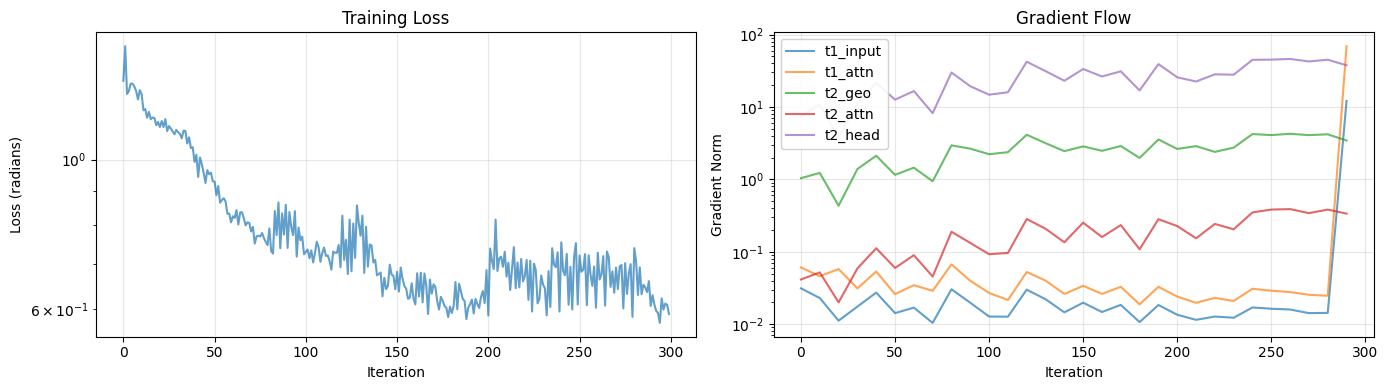

In [20]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reset model
model = HierarchicalTransformer(
    d_model=128,
    t1_n_heads=4,
    t1_n_layers=4,
    t1_max_seq_len=512,
    t1_max_batch_size=64,
    t2_n_heads=4,
    t2_n_layers=4,
    t2_max_doms=2048,
    dropout=0.0,  # Disable dropout for overfitting
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = AngularDistanceLoss(use_unit_vectors=False)

# Training loop
n_iters = 300
losses = []
grad_norms = {
    't1_input': [],
    't1_attn': [],
    't2_geo': [],
    't2_attn': [],
    't2_head': [],
}

pbar = tqdm(range(n_iters), desc="Overfitting")
for i in pbar:
    optimizer.zero_grad()
    predictions = model(batch)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    
    # Track loss
    losses.append(loss.item())
    
    # Track gradient norms every 10 steps
    if i % 10 == 0:
        grad_norms['t1_input'].append(model.t1.input_projection.weight.grad.norm().item())
        grad_norms['t1_attn'].append(model.t1.layers[0].qkv_proj.weight.grad.norm().item())
        grad_norms['t2_geo'].append(model.t2.geometry_encoder[0].weight.grad.norm().item())
        grad_norms['t2_attn'].append(model.t2.transformer.layers[0].self_attn.in_proj_weight.grad.norm().item())
        grad_norms['t2_head'].append(model.t2.prediction_head[0].weight.grad.norm().item())
    
    # Update progress bar
    pbar.set_postfix({'loss': f'{loss.item():.6f}'})

# Results
print(f"\n{'='*60}")
print(f"Initial loss: {losses[0]:.6f}")
print(f"Final loss:   {losses[-1]:.6f}")
print(f"Reduction:    {(1 - losses[-1]/losses[0])*100:.1f}%")
print(f"{'='*60}")

if losses[-1] < losses[0] * 0.1:
    print("✅ SUCCESS: Model can overfit")
elif losses[-1] < losses[0] * 0.5:
    print("⚠️  Partial success - needs investigation")
else:
    print("❌ FAIL: Model cannot overfit - check gradients above")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
axes[0].plot(losses, linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss (radians)')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Gradient norms
grad_steps = np.arange(0, n_iters, 10)
for name, norms in grad_norms.items():
    axes[1].plot(grad_steps, norms, label=name, linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Gradient Norm')
axes[1].set_title('Gradient Flow')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()